In [1]:
from time import time
try:
    import flax.linen as nn
except:
    !pip install flax
    import flax.linen as nn

import jax
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu
import jax.numpy as jnp
import pandas as pd
# jnp.set_printoptions(linewidth=2000)

try:
    import optax
except:
    !pip install optax
    import optax

from tqdm import trange
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
jax.config.update("jax_enable_x64", False)
import sys
sys.path.append('../')
from bijax.laplace import Laplace

# %reload_ext watermark

In [2]:
class MLP(nn.Module):
    features: list

    @nn.compact  
    def __call__(self, x):
        for i, feature in enumerate(self.features):
            x = nn.Dense(feature, name=f"{i}_Dense")(x)
            if i != len(self.features)-1:
                x = nn.relu(x)
        return x   

((60, 1), (60, 1))

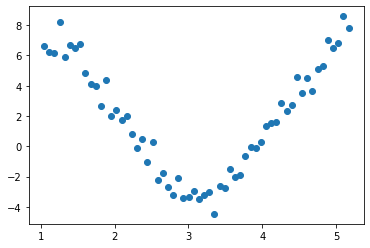

In [3]:
# Data
k1, k2 = jax.random.split(jax.random.PRNGKey(20), 2)
X = jnp.array([i*jnp.pi/180 for i in range(60,300,4)]).reshape(-1,1) 
y = 5*jnp.sin(1.5*X) + 2 + 0.7*jax.random.normal(k1,X.shape)
plt.scatter(X, y)
X.shape, y.shape

Final Loss: 1304.9672


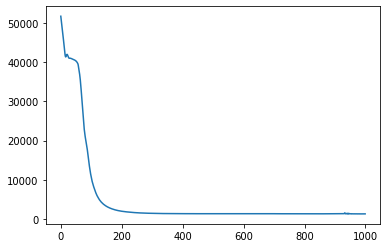

In [4]:
features = [2, 5, 1]
model = MLP(features)

prior = {"params": tfd.Normal(0,1)}
bijector = {"params": tfb.Identity()}
laplace = Laplace(prior, bijector, model=model, is_flax_model=True, subset_of_weights="all", hessian_structure="kfac")

# key={'params': jax.random.PRNGKey(0)}
key = jax.random.PRNGKey(0)
map_params = laplace.fit(X, y, key)
laplace_dist = laplace.laplace_distribution


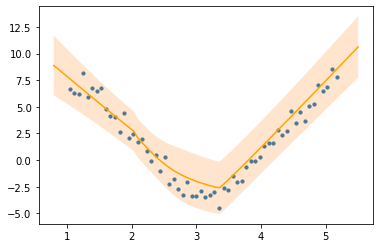

In [5]:
n_samples=1000
X_range = jnp.linspace(0.8,5.5,200).reshape(-1,1)
y_pred = laplace_dist.predict(X_range, seed=jax.random.PRNGKey(10), shape=(n_samples,))

y_pred_mean, y_pred_std = y_pred.mean(axis=0), y_pred.std(axis=0)
plt.scatter(X, y, 10)
# plt.scatter(X, y_map)
plt.plot(X_range, y_pred_mean, c="orange")
plt.fill_between(X_range.squeeze(), (y_pred_mean-1.96*y_pred_std).squeeze(), (y_pred_mean+1.96*y_pred_std).squeeze(), alpha=0.2)

### Last Layer

Final Loss: 1304.9672


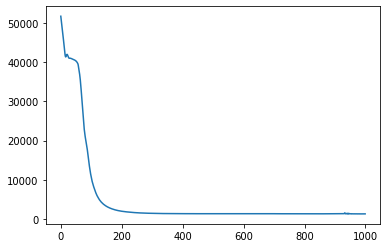

In [6]:
features = [2, 5, 1]
model = MLP(features)

prior = {"params": tfd.Normal(0,1)}
bijector = {"params": tfb.Identity()}
laplace = Laplace(prior, bijector, model=model, is_flax_model=True, subset_of_weights="last_layer", hessian_structure="full")

# key={'params': jax.random.PRNGKey(0)}
key = jax.random.PRNGKey(0)
map_params = laplace.fit(X, y, key)
laplace_dist = laplace.laplace_distribution


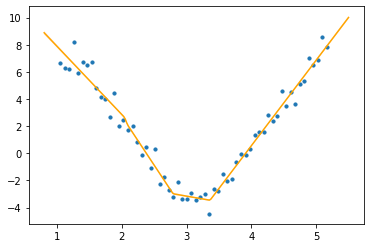

In [7]:
n_samples=1000
X_range = jnp.linspace(0.8,5.5,200).reshape(-1,1)
y_pred = laplace_dist.predict(X_range, seed=jax.random.PRNGKey(10), shape=(n_samples,))

y_pred_mean, y_pred_std = y_pred.mean(axis=0), y_pred.std(axis=0)
plt.scatter(X, y, 10)
# plt.scatter(X, y_map)
plt.plot(X_range, y_pred_mean, c="orange")
plt.fill_between(X_range.squeeze(), (y_pred_mean-1.96*y_pred_std).squeeze(), (y_pred_mean+1.96*y_pred_std).squeeze(), alpha=0.2)

### Data 2

In [8]:
def load_multinoise(seed):
    N = 100
    key, subkey = jax.random.split(seed)
    X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5).reshape(-1, 1)
    X_test = jax.random.uniform(key, shape=(200, 1), minval=-0.5, maxval=1.0).reshape(-1, 1)
    def f(seed, x):
        epsilons = jax.random.normal(seed, shape=(3,)) * 0.02
        return x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
    target_vmap = jax.vmap(f)
    keys = jax.random.split(subkey, X.shape[0])
    y = target_vmap(keys, X)# + jax.random.normal(subkey, shape=(X.shape[0], 1))*0.02
    idx = jnp.argsort(X.ravel())
    return X[idx], y[idx].ravel(), X_test.sort(axis=0)

((100, 1), (100,))

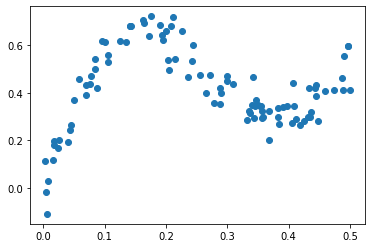

In [9]:
seed = jax.random.PRNGKey(10)
X, y, X_test = load_multinoise(seed)
# X, y, X_test = rd.SineNoisy().get_data()

plt.scatter(X, y)
X.shape, y.shape

((100, 1), (100,))

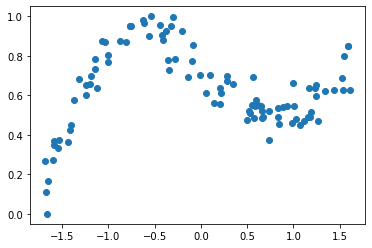

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1,1)).ravel()

plt.scatter(X, y)
X.shape, y.shape

Final Loss: 6968.6035


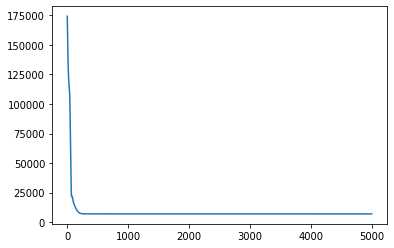

In [11]:
features = [16, 8, 1]
# features = [64, 32, 16, 1]
model = MLP(features)
prior = {"params": tfd.Normal(0,1)}
bijector = {"params": tfb.Identity()}
laplace = Laplace(prior, bijector, model=model, is_flax_model=True, subset_of_weights="all", hessian_structure="kfac")

key = jax.random.PRNGKey(5)
map_params = laplace.fit(X, y, key, lr=0.001, epochs=5000, only_map=True)
laplace_dist = laplace.laplace_distribution

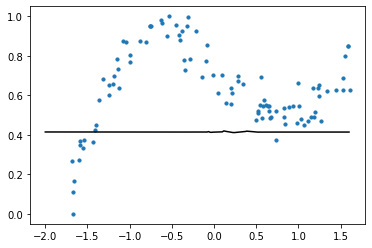

In [12]:
n_samples=1000
X_range = jnp.linspace(-2, 1.6, 200).reshape(-1,1)
y_map = model.apply(map_params, X_range)
y_map = y_scaler.inverse_transform(y_map)
# y_pred = laplace_dist.predict(X_range, seed=jax.random.PRNGKey(10), shape=(n_samples,))
# y_pred_mean, y_pred_std = y_pred.mean(axis=0), y_pred.std(axis=0)

plt.scatter(X, y, 10)
plt.plot(X_range, y_map, c="k")
# plt.plot(X_range, y_pred_mean, c="orange")
# plt.fill_between(X_range.squeeze(), (y_pred_mean-1.96*y_pred_std).squeeze(), (y_pred_mean+1.96*y_pred_std).squeeze(), alpha=0.2)